## Text Scraping and Classification</h2>

In [1]:
from IPython.display import display, HTML, Image

import pandas as pd
import numpy as np
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns
import os
import urllib.request
import bs4
import re
import time

from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import nltk
# nltk.download('stopwords')

from sklearn.cross_validation import train_test_split
from sklearn import neighbors
from sklearn import svm
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

C:\Users\windows\AppData\Roaming\Python\Python36\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Task 1: Data Collection

#### Read the link and generate the html parser

HTML parser function which takes link as an input and returns the parser of the page

In [2]:
def get_parser(link):
    response = urllib.request.urlopen(link)
    html = response.read().decode()
    parser = bs4.BeautifulSoup(html,"html.parser")
    return parser

#### Get the links and month titles from home page

In [3]:
prefix = 'http://mlg.ucd.ie/modules/COMP41680/archive/'
home = prefix
parser = get_parser(home)

# Save all the links and titles in a list
home_links = [ prefix + link['href'] for link in parser.select('li > a')]
home_titles = [ link.get_text() for link in parser.select('li > a')]

#### Create folder structure

In [4]:
# Create folders for data and each month, if does not exist
try:
    if not os.path.exists("data"):
        os.makedirs("data")
    for month in home_titles:
        directory = 'data/'+month
        if not os.path.exists(directory):
            os.makedirs(directory)
except:
    None

#### Get the content of the article

Function to download the content of the article.
Input parameters:
    - HTML Parser for the article
    - Directory path where file need to be saved
    - File name 

In [5]:
def get_article_content(html, directory, fileName):
    
    # Get the content within the paragraph and then join them into single string.
    para = [ match.get_text() for match in html.findAll('p', class_= False) if len(match.get_text())>0]
    content = ' '.join(para)
    
    # Save the article content in a file
    file = 'data/' + directory + '/' + fileName + '.txt'
    np.savetxt(file, [content.encode("utf-8")], fmt="%s")

#### Get all links at monthly level and generate title_category data

Function to fetch all the links and categories present for each article within every month
Input parameters for function: 
    - HTML Parser for month page with all the article list on it
    - Month for which data is being processed

In [6]:
def get_article_links(html, month):
    
    global labels
    
    # Get the list of category, links and titles from the month level page
    category = [ label.get_text()[1:] for label in html.select('td.category') if "N/A" not in label.get_text() ]
    titles = [ title.get_text()[1:] for title in html.select('td.title') if "no longer" not in title.get_text() ]
    links = [ prefix + link['href'] for link in html.select('td.title > a') ]
    
    # For each link fetch the table content 
    for i, link in enumerate(links):
        parser = get_parser(link) # Function defined above
        fileName = re.sub('[^A-Za-z0-9 ]+', '', titles[i]) # Pre-process the title 
        get_article_content(parser, month, fileName ) # Function defined above
        labels = labels.append([[fileName, category[i]]]) # Create the list of category/ lables for each article
    print('Successfully pulled {} articles for: {}'.format( len(links) ,month))
    

#### Pull all data

In [7]:
labels = pd.DataFrame()
for i, link in enumerate(home_links):
    parser = get_parser(link) # Function defined above
    get_article_links(parser, home_titles[i]) # Function defined above

Successfully pulled 118 articles for: January
Successfully pulled 122 articles for: February
Successfully pulled 116 articles for: March
Successfully pulled 117 articles for: April
Successfully pulled 114 articles for: May
Successfully pulled 114 articles for: June
Successfully pulled 122 articles for: July
Successfully pulled 116 articles for: August
Successfully pulled 112 articles for: September
Successfully pulled 122 articles for: October
Successfully pulled 121 articles for: November
Successfully pulled 114 articles for: December


#### Save the title_category mapping file

In [8]:
labels.columns = ['title', 'category']
labels.reset_index(drop = True, inplace = True)
labels.to_csv('title_category.csv', index = False)
labels.head()

,title,category
0,21stCentury Sports How Digital Technology Is C...,technology
1,Asian quake hits European shares,business
2,BT offers free net phone calls,technology
3,Barclays shares up on merger talk,business
4,Barkley fit for match in Ireland,sport


In [9]:
print("Total articles: {}".format(len(labels)))

Total articles: 1408


## Task 2: Text Classification

### Load the scraped data

In [10]:
# [file[:-4] for folder in os.listdir('data/') for file in os.listdir('data/'+folder)]

# Loop through each folder and file and fetch their content in a dataframe
df_raw = pd.DataFrame()
for folder in os.listdir('data/'):
    for file in os.listdir('data/' + folder):
        filePath = 'data/' + folder + '/' + file # Provides the path of the file
        with open(filePath, 'r') as myfile: # Read the file content
            content=myfile.read().replace('\n', '')
        df_raw = df_raw.append([[file[:-4], content]]) # Remove the ".txt" from the file name

df_raw.columns = ['title', 'content']

In [11]:
# Load the title, category mapping file so we can map it with the content
category = pd.read_csv('title_category.csv')
category = category.drop_duplicates() # Some duplicates were article name, category were found. Remove the duplicates
category.head()

,title,category
0,21stCentury Sports How Digital Technology Is C...,technology
1,Asian quake hits European shares,business
2,BT offers free net phone calls,technology
3,Barclays shares up on merger talk,business
4,Barkley fit for match in Ireland,sport


#### Join the category(labels) with the data 

In [12]:
df = pd.merge(df_raw, category, on='title') # Join the two dataset
df.head()

,title,content,category
0,Axa Sun Life cuts bonus payments,b'Axa Sun Life cuts bonus payments Life insure...,business
1,Bates seals takeover,b'Ken Bates has completed his takeover of Leed...,sport
2,Beckham virus spotted on the net,b'Virus writers are trading on interest in Dav...,technology
3,Broadband fuels online expression,b'Fast web access is encouraging more people t...,technology
4,Broadband in the UK gathers pace,b'Broadband in the UK gathers pace One person ...,technology


In [13]:
df.isnull().sum()

title       0
content     0
category    0
dtype: int64

In [14]:
df.category.value_counts()

sport         526
business      491
technology    391
Name: category, dtype: int64

### Preprocessing & Document Term Matrix

#### Tokenize and Stemming

In [15]:
# Convert to lower case
df['title'] = df['title'].str.lower()
df['content'] = df['content'].str.lower()

In [16]:
corpus = []
tokenize = CountVectorizer().build_tokenizer() # Create the tokenizer
t = time.time()
for i in range(0, len(df)): # loop through each article
    content = tokenize(df['content'][i]) # Tokenize the article content
    ps = PorterStemmer() 
    # Remove stop words and do stemming
    content = [ps.stem(word) for word in content if not word in set(stopwords.words('english'))] 
    content = ' '.join(content) # Join the tokens back to single string
    corpus.append(content) # Add the the list
    
print(time.time() - t) # Time to do above pre-processing

155.36188626289368


#### TFidf Matrix creation

In [17]:
# Create the TF-IDF Vectorizer, with arguments to remove stop words and take only 10,000 features
vectorizer = TfidfVectorizer(stop_words="english", max_features = 10000)
X = vectorizer.fit_transform(corpus).toarray()
y = df['category'].values

In [18]:
# Display the TF-IDF matrix
vector_space = pd.DataFrame(data=X, index=df['title'], columns=vectorizer.get_feature_names())
vector_space.head()

,00,000,000m,007,01,02,03,04,04sec,05,...,zinc,zinedin,zip,zodiac,zola,zombi,zone,zoom,zurich,zvonareva
title,,,,,,,,,,,,,,,,,,,,,
axa sun life cuts bonus payments,0.0,0.027332,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
bates seals takeover,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
beckham virus spotted on the net,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
broadband fuels online expression,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
broadband in the uk gathers pace,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
vector_space.head(100).describe()

,00,000,000m,007,01,02,03,04,04sec,05,...,zinc,zinedin,zip,zodiac,zola,zombi,zone,zoom,zurich,zvonareva
count,100.0,100.000000,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.000000,...,100.0,100.0,100.000000,100.0,100.0,100.0,100.0,100.0,100.000000,100.0
mean,0.0,0.005505,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000845,...,0.0,0.0,0.000683,0.0,0.0,0.0,0.0,0.0,0.001188,0.0
std,0.0,0.015176,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.008453,...,0.0,0.0,0.006827,0.0,0.0,0.0,0.0,0.0,0.008505,0.0
min,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
25%,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
50%,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
75%,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
max,0.0,0.071318,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.084528,...,0.0,0.0,0.068273,0.0,0.0,0.0,0.0,0.0,0.070437,0.0


### Classification Algorithms

In [20]:
cv_folds = 10
model_test_accuracy_comparisons = dict()
model_valid_accuracy_comparisons = dict()
model_tuned_params_list = dict()
model_accuracy = pd.DataFrame()

In [21]:
X_train_plus_valid, X_test, y_train_plus_valid, y_test \
    = train_test_split(X, y, random_state=0, \
                                    train_size = 0.7)

X_train, X_valid, y_train, y_valid \
    = train_test_split(X_train_plus_valid, \
                                        y_train_plus_valid, \
                                        random_state=0, \
                                        train_size = 0.5/0.7)


### KNN Classifier

In [22]:
my_model = neighbors.KNeighborsClassifier()
my_model.fit(X_train,y_train, )

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [23]:
# Make a set of predictions for the valid data
y_pred = my_model.predict(X_valid)

# Print performance details
accuracy = metrics.accuracy_score(y_valid, y_pred) 
model_valid_accuracy_comparisons["kNN"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_valid, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_valid), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.950354609929078
             precision    recall  f1-score   support

   business       0.97      0.91      0.94       101
      sport       0.98      0.96      0.97       100
 technology       0.90      0.99      0.94        81

avg / total       0.95      0.95      0.95       282

Confusion Matrix


Predicted,business,sport,technology,All
True,,,,
business,92,2,7,101
sport,2,96,2,100
technology,1,0,80,81
All,95,98,89,282


In [24]:
# Set up the parameter grid to seaerch
param_grid = [
               {'n_neighbors': list(range(1, 10, 2))}
]

# Perform the search
my_tuned_model = GridSearchCV(neighbors.KNeighborsClassifier(), param_grid, cv=4, verbose = 2)
my_tuned_model.fit(X_train_plus_valid, y_train_plus_valid)

# Print details
print("Best parameters set found on development set:")
print(my_tuned_model.best_params_)
model_tuned_params_list["Tuned kNN"] = my_tuned_model.best_params_
print(my_tuned_model.best_score_)

Fitting 4 folds for each of 5 candidates, totalling 20 fits
[CV] n_neighbors=1 ...................................................
[CV] .................................... n_neighbors=1, total=   2.8s
[CV] n_neighbors=1 ...................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.9s remaining:    0.0s


[CV] .................................... n_neighbors=1, total=   2.8s
[CV] n_neighbors=1 ...................................................
[CV] .................................... n_neighbors=1, total=   2.8s
[CV] n_neighbors=1 ...................................................
[CV] .................................... n_neighbors=1, total=   2.9s
[CV] n_neighbors=3 ...................................................
[CV] .................................... n_neighbors=3, total=   3.0s
[CV] n_neighbors=3 ...................................................
[CV] .................................... n_neighbors=3, total=   3.1s
[CV] n_neighbors=3 ...................................................
[CV] .................................... n_neighbors=3, total=   3.0s
[CV] n_neighbors=3 ...................................................
[CV] .................................... n_neighbors=3, total=   3.1s
[CV] n_neighbors=5 ...................................................
[CV] .

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  3.4min finished


Best parameters set found on development set:
{'n_neighbors': 9}
0.966497461928934


In [25]:
# Make a set of predictions for the test data
y_pred = my_tuned_model.predict(X_test)

# Print performance details
accuracy = metrics.accuracy_score(y_test, y_pred) # , normalize=True, sample_weight=None
model_test_accuracy_comparisons["Tuned kNN"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_test, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_test), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.9692671394799054
             precision    recall  f1-score   support

   business       0.97      0.95      0.96       144
      sport       0.99      0.98      0.98       156
 technology       0.94      0.98      0.96       123

avg / total       0.97      0.97      0.97       423

Confusion Matrix


Predicted,business,sport,technology,All
True,,,,
business,137,1,6,144
sport,2,153,1,156
technology,2,1,120,123
All,141,155,127,423


In [26]:
# Get the cross validation accuracy of the model.
accuracy_cv = cross_val_score(my_tuned_model.best_estimator_, X_train_plus_valid, y_train_plus_valid, cv=10)
knn_accuracy = pd.DataFrame({'model': pd.Series(np.repeat('knn',10)), 'accuracy': pd.Series(accuracy_cv)})
model_accuracy = knn_accuracy.copy()
model_accuracy

,accuracy,model
0,0.979798,knn
1,0.979798,knn
2,0.909091,knn
3,0.979798,knn
4,0.939394,knn
5,0.969697,knn
6,0.979798,knn
7,0.989796,knn
8,0.958763,knn
9,0.969072,knn


### SVM Classifier

In [27]:
my_model = svm.LinearSVC()
my_model = my_model.fit(X_train,y_train)

In [28]:
# Make a set of predictions for the valid data
y_pred = my_model.predict(X_valid)

# Print performance details
accuracy = metrics.accuracy_score(y_valid, y_pred) # , normalize=True, sample_weight=None
model_valid_accuracy_comparisons["SVM"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_valid, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_valid), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.9787234042553191
             precision    recall  f1-score   support

   business       0.99      0.96      0.97       101
      sport       0.99      0.98      0.98       100
 technology       0.95      1.00      0.98        81

avg / total       0.98      0.98      0.98       282

Confusion Matrix


Predicted,business,sport,technology,All
True,,,,
business,97,1,3,101
sport,1,98,1,100
technology,0,0,81,81
All,98,99,85,282


In [29]:
# Set up the parameter grid to seaerch
param_grid = [
             {'C': [ 0.01, 0.1,0.5,  1,] }
]

# Perform the search
my_tuned_model = GridSearchCV(svm.LinearSVC(), param_grid, cv=cv_folds, verbose = 2)
my_tuned_model.fit(X_train_plus_valid, y_train_plus_valid)

# Print details
print("Best parameters set found on development set:")
print(my_tuned_model.best_params_)
model_tuned_params_list["Tuned SVM"] = my_tuned_model.best_params_
print(my_tuned_model.best_score_)

Fitting 10 folds for each of 4 candidates, totalling 40 fits
[CV] C=0.01 ..........................................................
[CV] ........................................... C=0.01, total=   0.0s
[CV] C=0.01 ..........................................................
[CV] ........................................... C=0.01, total=   0.0s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ........................................... C=0.01, total=   0.0s
[CV] C=0.01 ..........................................................
[CV] ........................................... C=0.01, total=   0.0s
[CV] C=0.01 ..........................................................
[CV] ........................................... C=0.01, total=   0.0s
[CV] C=0.01 ..........................................................
[CV] ........................................... C=0.01, total=   0.0s
[CV] C=0.01 ..........................................................
[CV] ........................................... C=0.01, total=   0.0s
[CV] C=0.01 ..........................................................
[CV] ........................................... C=0.01, total=   0.0s
[CV] C=0.01 ..........................................................
[CV] ........................................... C=0.01, total=   0.0s
[CV] C=0.01 ..........................................................
[CV] .

[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    4.5s finished


In [30]:
# Make a set of predictions for the test data
y_pred = my_tuned_model.predict(X_test)

# Print performance details
accuracy = metrics.accuracy_score(y_test, y_pred) # , normalize=True, sample_weight=None
model_test_accuracy_comparisons["Tuned SVM"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_test, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_test), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.9810874704491725
             precision    recall  f1-score   support

   business       0.99      0.98      0.98       144
      sport       0.99      0.99      0.99       156
 technology       0.97      0.98      0.97       123

avg / total       0.98      0.98      0.98       423

Confusion Matrix


Predicted,business,sport,technology,All
True,,,,
business,141,0,3,144
sport,1,154,1,156
technology,1,2,120,123
All,143,156,124,423


In [31]:
# Get the cross validation accuracy of the model.

accuracy_cv = cross_val_score(my_tuned_model.best_estimator_, X_train_plus_valid, y_train_plus_valid, cv=10)
svm_accuracy = pd.DataFrame({'model': pd.Series(np.repeat('svm',10)), 'accuracy': pd.Series(accuracy_cv)})
models_accuracy = pd.concat([model_accuracy, svm_accuracy])
models_accuracy['x'] = "Points"

### Accuracy Comparison

#### Compare the accuracy of KNN and SVM

In [32]:
print("Base Model Accuracy: ", model_valid_accuracy_comparisons)
print("Tuned Model Accuracy: ", model_test_accuracy_comparisons)

Base Model Accuracy:  {'kNN': 0.950354609929078, 'SVM': 0.9787234042553191}
Tuned Model Accuracy:  {'Tuned kNN': 0.9692671394799054, 'Tuned SVM': 0.9810874704491725}


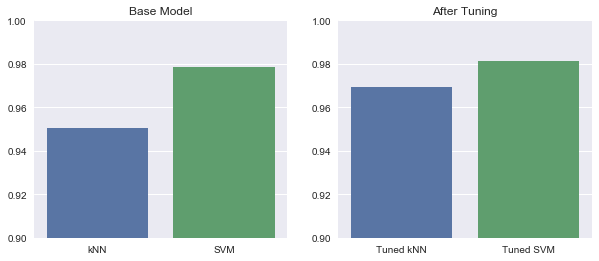

In [33]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,4))
sns.barplot(list(model_valid_accuracy_comparisons.keys()), list(model_valid_accuracy_comparisons.values()), ax = ax1)
ax1.set_ylim(0.90,1)
ax1.set_title("Base Model")

sns.barplot(list(model_test_accuracy_comparisons.keys()), list(model_test_accuracy_comparisons.values()), ax = ax2)
ax2.set_ylim(0.90,1)
ax2.set_title("After Tuning")

#### Deviation in the crossvalidation score of KNN and SVM for 10 folds

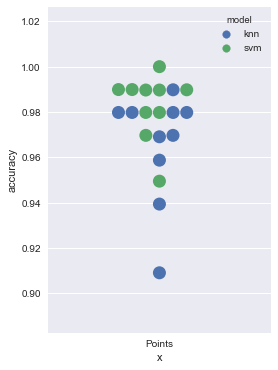

In [34]:
fig, _ = plt.subplots(figsize=(4,6))
sns.swarmplot(x = "x", y="accuracy", hue="model", data=models_accuracy, size=13)

#### Conclusion
From the above bar chart we can observe that SVM is performing better than KNN. Also when looked the swarm plot to see the deviation in different rounds of algorithm, most of the time SVM gave better results than KNN. So for our use case, we can use SVM to predict category for the articles coming in future.

##### Future:
In a long run or in case of generic News website, we can run a classifier on article title and on the writer as well and can create a weigted metric using these 3 models to better predict the new articles category.